Data Preprocessing

In [14]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

def get_data_loaders(train_dir, val_dir, test_dir, batch_size=32):
    # Define the image transformations with data augmentation
    transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # Load datasets using ImageFolder
    train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
    val_dataset = datasets.ImageFolder(root=val_dir, transform=transform)
    test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader, train_dataset.classes, len(train_dataset.classes)

# Example usage:
if __name__ == "__main__":
    train_loader, val_loader, test_loader, class_names, num_classes = get_data_loaders(
        'data/train', 'data/validation', 'data/test'
    )
    print(f"Number of classes: {num_classes}")
    print(f"Classes: {class_names}")


Number of classes: 9
Classes: ['Center', 'Donut', 'Edge-Loc', 'Edge-Ring', 'Loc', 'Near-full', 'Random', 'Scratch', 'none']


Train Model

In [15]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torchvision.models import ResNet50_Weights
from tqdm import tqdm  # For progress bar
from data_preprocessing import get_data_loaders  # Import your data loader function
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

In [16]:
# Define paths to your dataset
train_dir = "data//train"
val_dir = "data//validation"
test_dir = "data//test"

In [17]:
# Load data loaders
train_loader, val_loader, test_loader, class_names, num_classes = get_data_loaders(train_dir, val_dir, test_dir)

In [18]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")  # Check which device is being used

Using device: cuda


In [19]:
# Load the pretrained ResNet50 model
model = models.resnet50(weights=ResNet50_Weights.DEFAULT)

In [20]:
# Modify the final layer for your number of classes
num_classes = len(class_names)
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Move model to the appropriate device
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [21]:
# Set the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [22]:
# Load the model if resuming training
model_path = 'model_epoch_last.pth'
resume_epoch = 0
if os.path.exists('model_epoch_last.pth'):  # Change to your latest saved model file name
    model.load_state_dict(torch.load('model_epoch_last.pth'))
    print("Model loaded for resuming training.")
    resume_epoch = int(model_path.split('_')[-1].split('.')[0])  # Assumes format 'model_epoch_X.pth'
    print(f"Model loaded for resuming training from epoch {resume_epoch}.")

In [23]:
# Initialize variables for early stopping
best_val_loss = float('inf')
patience = 5
epochs_without_improvement = 0

# Track losses and accuracy for visualization
train_losses, val_losses = [], []
val_accuracies = []

In [24]:
# Training loop
num_epochs = 20  # Adjust as necessary
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")
    if (epoch + 1) % 2 == 0:
        torch.save(model.state_dict(), f'model_epoch_{epoch+1}.pth')  # Save as the last model
        print(f"Model saved after epoch {epoch + 1}.")

    # Validation loop
    model.eval()  # Set the model to evaluation mode
    val_loss=0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss=criterion(outputs,labels)
            val_loss+=loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Calculate and print average validation loss and accuracy for the epoch
    avg_val_loss = val_loss / len(val_loader)
    val_loss /= len(val_loader)
    val_accuracy = 100 * correct / total

    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")
    # print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0
        torch.save(model.state_dict(), 'best_model.pth')  # Save the best model
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= patience:
            print(f"Early stopping triggered after epoch {epoch+1}")
            break  # Exit the training loop

    if (epoch + 1) % 2 == 0:
        torch.save(model.state_dict(), f'model_epoch_{epoch+1}.pth')  # Save checkpoint every 2 epochs
        print(f"Model checkpoint saved after epoch {epoch + 1}.")

100%|██████████| 1830/1830 [10:13<00:00,  2.98it/s]


Epoch [1/20], Loss: 0.3936
Epoch [1/20], Train Loss: 0.3936, Validation Loss: 0.2000, Validation Accuracy: 93.38%


100%|██████████| 1830/1830 [13:59<00:00,  2.18it/s]


Epoch [2/20], Loss: 0.2183
Model saved after epoch 2.
Epoch [2/20], Train Loss: 0.2183, Validation Loss: 0.1827, Validation Accuracy: 93.46%
Model checkpoint saved after epoch 2.


100%|██████████| 1830/1830 [14:25<00:00,  2.11it/s]


Epoch [3/20], Loss: 0.1881
Epoch [3/20], Train Loss: 0.1881, Validation Loss: 0.1558, Validation Accuracy: 94.44%


100%|██████████| 1830/1830 [14:39<00:00,  2.08it/s]


Epoch [4/20], Loss: 0.1652
Model saved after epoch 4.
Epoch [4/20], Train Loss: 0.1652, Validation Loss: 0.1410, Validation Accuracy: 95.08%
Model checkpoint saved after epoch 4.


100%|██████████| 1830/1830 [14:48<00:00,  2.06it/s]


Epoch [5/20], Loss: 0.1512
Epoch [5/20], Train Loss: 0.1512, Validation Loss: 0.1396, Validation Accuracy: 95.21%


100%|██████████| 1830/1830 [11:39<00:00,  2.62it/s]


Epoch [6/20], Loss: 0.1399
Model saved after epoch 6.
Epoch [6/20], Train Loss: 0.1399, Validation Loss: 0.1297, Validation Accuracy: 95.30%
Model checkpoint saved after epoch 6.


100%|██████████| 1830/1830 [11:38<00:00,  2.62it/s]


Epoch [7/20], Loss: 0.1246
Epoch [7/20], Train Loss: 0.1246, Validation Loss: 0.1232, Validation Accuracy: 95.76%


100%|██████████| 1830/1830 [11:24<00:00,  2.67it/s]


Epoch [8/20], Loss: 0.1177
Model saved after epoch 8.
Epoch [8/20], Train Loss: 0.1177, Validation Loss: 0.1153, Validation Accuracy: 95.97%
Model checkpoint saved after epoch 8.


100%|██████████| 1830/1830 [11:19<00:00,  2.69it/s]


Epoch [9/20], Loss: 0.1078
Epoch [9/20], Train Loss: 0.1078, Validation Loss: 0.1038, Validation Accuracy: 96.41%


100%|██████████| 1830/1830 [11:15<00:00,  2.71it/s]


Epoch [10/20], Loss: 0.1002
Model saved after epoch 10.
Epoch [10/20], Train Loss: 0.1002, Validation Loss: 0.1001, Validation Accuracy: 96.41%
Model checkpoint saved after epoch 10.


100%|██████████| 1830/1830 [12:29<00:00,  2.44it/s]


Epoch [11/20], Loss: 0.0928
Epoch [11/20], Train Loss: 0.0928, Validation Loss: 0.1030, Validation Accuracy: 96.47%


100%|██████████| 1830/1830 [12:27<00:00,  2.45it/s]


Epoch [12/20], Loss: 0.0867
Model saved after epoch 12.
Epoch [12/20], Train Loss: 0.0867, Validation Loss: 0.0995, Validation Accuracy: 96.51%
Model checkpoint saved after epoch 12.


100%|██████████| 1830/1830 [14:04<00:00,  2.17it/s]


Epoch [13/20], Loss: 0.0802
Epoch [13/20], Train Loss: 0.0802, Validation Loss: 0.0943, Validation Accuracy: 96.83%


100%|██████████| 1830/1830 [17:11<00:00,  1.77it/s]


Epoch [14/20], Loss: 0.0790
Model saved after epoch 14.
Epoch [14/20], Train Loss: 0.0790, Validation Loss: 0.0880, Validation Accuracy: 97.16%
Model checkpoint saved after epoch 14.


100%|██████████| 1830/1830 [13:47<00:00,  2.21it/s]


Epoch [15/20], Loss: 0.0700
Epoch [15/20], Train Loss: 0.0700, Validation Loss: 0.0815, Validation Accuracy: 97.28%


100%|██████████| 1830/1830 [10:04<00:00,  3.03it/s]


Epoch [16/20], Loss: 0.0663
Model saved after epoch 16.
Epoch [16/20], Train Loss: 0.0663, Validation Loss: 0.0795, Validation Accuracy: 97.43%
Model checkpoint saved after epoch 16.


100%|██████████| 1830/1830 [09:56<00:00,  3.07it/s]


Epoch [17/20], Loss: 0.0656
Epoch [17/20], Train Loss: 0.0656, Validation Loss: 0.0793, Validation Accuracy: 97.30%


100%|██████████| 1830/1830 [09:53<00:00,  3.08it/s]


Epoch [18/20], Loss: 0.0594
Model saved after epoch 18.
Epoch [18/20], Train Loss: 0.0594, Validation Loss: 0.0745, Validation Accuracy: 97.49%
Model checkpoint saved after epoch 18.


100%|██████████| 1830/1830 [09:50<00:00,  3.10it/s]


Epoch [19/20], Loss: 0.0564
Epoch [19/20], Train Loss: 0.0564, Validation Loss: 0.0780, Validation Accuracy: 97.58%


100%|██████████| 1830/1830 [10:04<00:00,  3.03it/s]


Epoch [20/20], Loss: 0.0550
Model saved after epoch 20.
Epoch [20/20], Train Loss: 0.0550, Validation Loss: 0.0705, Validation Accuracy: 97.68%
Model checkpoint saved after epoch 20.


In [25]:
# Save the final model
torch.save(model.state_dict(), 'final_model.pth')
print("Final model saved as final_model.pth")

Final model saved as final_model.pth


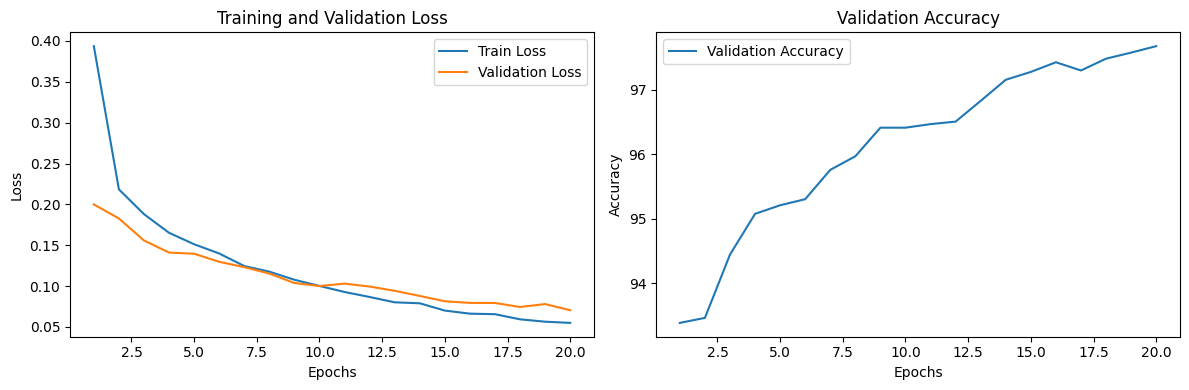

In [26]:
# Plotting the results
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(12, 4))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Validation Accuracy')

plt.tight_layout()
plt.show()

all_preds=[]
all_labels=[]

Test Accuracy: 97.74%


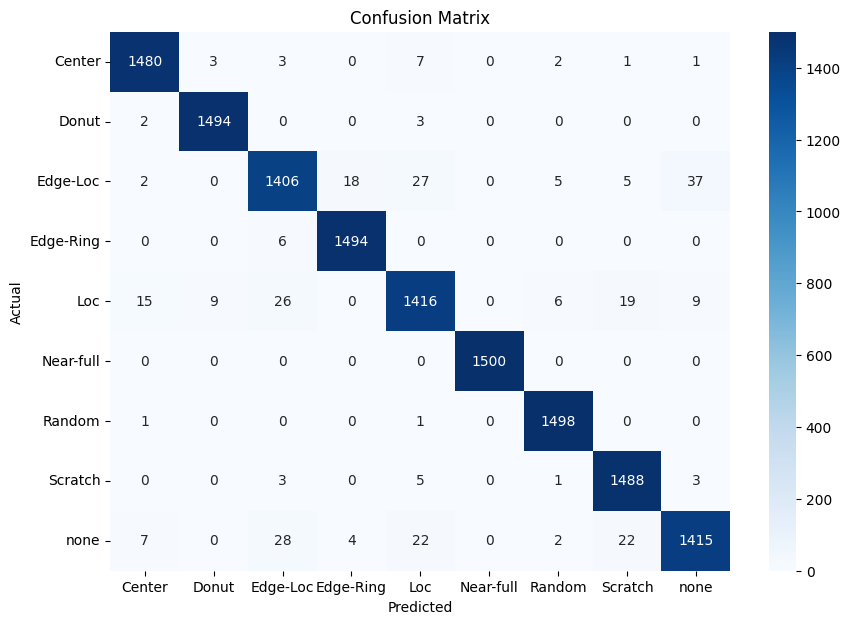

              precision    recall  f1-score   support

      Center       0.98      0.99      0.99      1497
       Donut       0.99      1.00      0.99      1499
    Edge-Loc       0.96      0.94      0.95      1500
   Edge-Ring       0.99      1.00      0.99      1500
         Loc       0.96      0.94      0.95      1500
   Near-full       1.00      1.00      1.00      1500
      Random       0.99      1.00      0.99      1500
     Scratch       0.97      0.99      0.98      1500
        none       0.97      0.94      0.95      1500

    accuracy                           0.98     13496
   macro avg       0.98      0.98      0.98     13496
weighted avg       0.98      0.98      0.98     13496



In [27]:
# Testing loop
model.eval()
test_correct = 0
test_total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

        # Store predictions and true labels
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(f"Test Accuracy: {100 * test_correct / test_total:.2f}%")

# Calculate confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Classification report
print(classification_report(all_labels, all_preds, target_names=class_names))